## Assignment #1 - Muna Al-Nemrawi, Batool Hamdallh

### 1 - Packages 

The cell below imports all the packages that we will need during this assignment.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

### 2 - Load Glove Embeddings
**Step 1 of the Assignment**
- Convert GloVe to Word2Vec Format
  </br>`glove2word2vec` converts the GloVe file (glove.6B.50d.txt) into a format that can be used by the gensim library
  </br></br>
- Load Embeddings with Gensim
  </br>`KeyedVectors.load_word2vec_format` function loads the converted embeddings into a KeyedVectors object, which allows us to easily access the word vectors

In [5]:
def load_glove_embeddings(glove_input_file, word2vec_output_file):
    """
    Convert GloVe format to Word2Vec format and load embeddings.
    """
    # Convert GloVe format to Word2Vec format
    glove2word2vec(glove_input_file, word2vec_output_file)
    
    # Load Word2Vec format embeddings using Gensim
    word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    return word_vectors

# Paths to GloVe files
glove_input_file = "glove.6B/glove.6B.50d.txt"
word2vec_output_file = "glove.6B/glove.6B.50d.word2vec.txt"

# Load the embeddings
word_vectors = load_glove_embeddings(glove_input_file, word2vec_output_file)

/var/folders/3q/qqkydbqd3cs819gns30k10840000gn/T/ipykernel_52483/3290131603.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


### 3 - Loading and Vectorizing the Data
**Step 2 of the Assignment**

- Retrieve Word Embeddings
  </br>The `process_review` function retrieves embeddings for each word in a review.
  </br>If a word is not found in word_vectors, it uses a default zero vector - <em>default_vector</em>.
  </br></br>
- Aggregate Embeddings for the Review
  </br>The `process_review` function computes the mean of the word embeddings to represent the review as a single 50-dimensional vector.

In [7]:
# Load the datasets
train_data = pd.read_csv("Dataset/train.csv")
test_data = pd.read_csv("Dataset/test.csv")
dev_data = pd.read_csv("Dataset/dev.csv")

# Default zero vector for missing words
default_vector = np.zeros(50)

def process_review(review, word_vectors):
    """
    Converts a single review into a 50-dimensional vector.
    - Retrieve embeddings for each word in the review.
    - Use the mean of the embeddings to represent the review.
    """
    word_embeddings = []
    for word in review.split():
        if word in word_vectors:
            word_embeddings.append(word_vectors[word])
        else:
            word_embeddings.append(default_vector)
    
    # Compute the mean vector for the review
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return default_vector

# Apply process_review to each review in the dataset, converting all reviews into their corresponding 50-dimensional vectors.
def process_reviews(data, word_vectors):
    review_vectors = [process_review(review, word_vectors) for review in data['review']]
    return np.array(review_vectors)


#### Preparing the Data

In [9]:
# Prepare data and map sentiments to binary values
X_train = process_reviews(train_data, word_vectors)
train_data['sentiment'] = train_data['sentiment'].map({'positive': 1, 'negative': 0})
y_train = train_data['sentiment'].values

X_test = process_reviews(test_data, word_vectors)
test_data['sentiment'] = test_data['sentiment'].map({'positive': 1, 'negative': 0})
y_test = test_data['sentiment'].values


X_val = process_reviews(dev_data, word_vectors)
dev_data['sentiment'] = dev_data['sentiment'].map({'positive': 1, 'negative': 0})
y_val = dev_data['sentiment'].values

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (1477, 50), y_train shape: (1477,)
X_test shape: (400, 50), y_test shape: (400,)
X_val shape: (400, 50), y_val shape: (400,)


### 4 - Normalization
**Step 3 of the Assignment**
- Min-Max Normalization
  </br>The `normalize_features` function calculates the minimum and maximum values for each feature from the training set.
  </br>It then applies min-max normalization to scale the feature values between 0 and 1.
- In this cell we calculate the minimum and maximum values of each feature only from the training set.

In [11]:
def normalize_features(X_train: np.ndarray, X_val: np.ndarray = None, X_test: np.ndarray = None):
    """
    Normalize features using min-max normalization.
    Calculate min and max only from the training set.
    """
    # Calculate min and max values from training data
    min_values, max_values = X_train.min(axis=0), X_train.max(axis=0)
    
    # Normalize training data
    X_train_normalized = (X_train - min_values) / (max_values - min_values)
    
    # Normalize validation and test data using training min/max
    X_val_normalized = (X_val - min_values) / (max_values - min_values) if X_val is not None else None
    X_test_normalized = (X_test - min_values) / (max_values - min_values) if X_test is not None else None
    
    return X_train_normalized, X_val_normalized, X_test_normalized


# Normalize the datasets
X_train_normalized, X_val_normalized, X_test_normalized = normalize_features(X_train, X_val, X_test)

### 5 - Logistic Regression
**Step 4 of the Assignment**
- Sigmoid function
  </br>The `sigmoid` function computes the sigmoid of z, which is essential for logistic regression.
- Loss and Gradients Calculation
  </br>The `compute_loss_and_gradients` function calculates the binary cross-entropy loss and the gradients for weights and bias.
- Mini-Batch Gradient Descent
  </br>The `mini_batch_gradient_descent` function trains the logistic regression model using mini-batch gradient descent.
  </br>It initializes weights and bias, shuffles the data, processes mini-batches, computes loss and gradients, and updates weights and bias.
  </br>It prints the loss and accuracy every 10 epochs to monitor training progress.

In [13]:
def sigmoid(z):
    """Compute the sigmoid of z."""
    return 1 / (1 + np.exp(-z))

def compute_loss_and_gradients(X, y, weights, bias):
    """Compute the binary cross-entropy loss and gradients."""
    m = X.shape[0]  # Number of samples
    
    # Compute predictions
    z = np.dot(X, weights) + bias
    predictions = sigmoid(z)
    
    # Compute loss
    loss = -(1 / m) * np.sum(y * np.log(predictions + 1e-8) + (1 - y) * np.log(1 - predictions + 1e-8))
    
    # Compute gradients
    dw = (1 / m) * np.dot(X.T, (predictions - y))
    db = (1 / m) * np.sum(predictions - y)
    
    return loss, dw, db

def mini_batch_gradient_descent_with_tracking(X: np.ndarray, y: np.ndarray, 
                                              X_val: np.ndarray, y_val: np.ndarray,
                                              learning_rate: float = 0.01, 
                                              epochs: int = 1000, batch_size: int = 16):
    """Train logistic regression using mini-batch gradient descent with accuracy and loss tracking."""
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Shuffle the data
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled, y_shuffled = X[indices], y[indices]

        # Process mini-batches
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
            
            # Compute gradients and update parameters
            loss, dw, db = compute_loss_and_gradients(X_batch, y_batch, weights, bias)
            weights -= learning_rate * dw
            bias -= learning_rate * db

        # Evaluate the full training set accuracy
        train_predictions = sigmoid(np.dot(X, weights) + bias) >= 0.5
        train_accuracy = np.mean(train_predictions == y)
        train_accuracies.append(train_accuracy)

        # Compute the full training loss
        train_loss, _, _ = compute_loss_and_gradients(X, y, weights, bias)
        train_losses.append(train_loss)

        # Evaluate the validation set accuracy
        val_predictions = sigmoid(np.dot(X_val, weights) + bias) >= 0.5
        val_accuracy = np.mean(val_predictions == y_val)
        val_accuracies.append(val_accuracy)

        # Compute the validation loss
        val_loss, _, _ = compute_loss_and_gradients(X_val, y_val, weights, bias)
        val_losses.append(val_loss)

        # Print every 10 epochs
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
                  f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}")

    return weights, bias, train_accuracies, val_accuracies, train_losses, val_losses

### 6 - Validation and Hyperparameter Tuning
Using the validation (dev) data to tune our hyper-parameters and using the test data to report the accuracy of the trained mode

In [15]:
def evaluate_model(X_train: np.ndarray, y_train: np.ndarray, 
                   X_val: np.ndarray, y_val: np.ndarray, 
                   learning_rates: list, epochs: int, batch_sizes: list):
    """
    Evaluate logistic regression model for different learning rates and batch sizes.
    """
    results = []

    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Testing learning_rate={lr}, batch_size={batch_size}")

            # Train the model using mini-batch gradient descent
            weights, bias, train_accuracies, val_accuracies, _, _ = mini_batch_gradient_descent_with_tracking(
                X_train, y_train, X_val, y_val, learning_rate=lr, epochs=epochs, batch_size=batch_size
            )

            # Compute validation accuracy
            val_predictions = sigmoid(np.dot(X_val, weights) + bias) >= 0.5
            val_accuracy = np.mean(val_predictions == y_val)

            # Store the result
            results.append({"learning_rate": lr, "batch_size": batch_size, "accuracy": val_accuracy})
            print(f"Validation Accuracy: {val_accuracy:.4f}")

    return results

# Hyperparameter tuning
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [16, 32, 64]
epochs = 1000

# Evaluate models with different hyperparameters
validation_results = evaluate_model(
    X_train_normalized, y_train, X_val_normalized, y_val, 
    learning_rates, epochs, batch_sizes
)

# Find the best hyperparameters
best_model = max(validation_results, key=lambda x: x['accuracy'])
print("Best Hyperparameters:", best_model)

Testing learning_rate=0.1, batch_size=16
Epoch 50: Train Loss = 0.5001, Train Accuracy = 0.7664, Validation Loss = 0.5316, Validation Accuracy = 0.7500
Epoch 100: Train Loss = 0.4804, Train Accuracy = 0.7712, Validation Loss = 0.5076, Validation Accuracy = 0.7625
Epoch 150: Train Loss = 0.4812, Train Accuracy = 0.7678, Validation Loss = 0.5024, Validation Accuracy = 0.7650
Epoch 200: Train Loss = 0.4983, Train Accuracy = 0.7529, Validation Loss = 0.5129, Validation Accuracy = 0.7525
Epoch 250: Train Loss = 0.4722, Train Accuracy = 0.7806, Validation Loss = 0.5028, Validation Accuracy = 0.7550
Epoch 300: Train Loss = 0.4726, Train Accuracy = 0.7745, Validation Loss = 0.5005, Validation Accuracy = 0.7600
Epoch 350: Train Loss = 0.4709, Train Accuracy = 0.7745, Validation Loss = 0.5012, Validation Accuracy = 0.7575
Epoch 400: Train Loss = 0.4761, Train Accuracy = 0.7773, Validation Loss = 0.5164, Validation Accuracy = 0.7300
Epoch 450: Train Loss = 0.4703, Train Accuracy = 0.7759, Validat

### 7 - Final Evaluation on the Test Dataset

In [17]:
def final_evaluation_on_test(X_train, y_train, X_val, y_val, X_test, y_test, 
                             learning_rates, epochs, batch_sizes):
    """
    Perform final evaluation on the test dataset after tuning hyperparameters on validation data.
    """
    best_model = None
    best_weights, best_bias = None, None
    best_accuracy = 0

    # Tune hyperparameters on validation data
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Testing learning_rate={lr}, batch_size={batch_size}")
            weights, bias, train_accuracies, val_accuracies, _, _ = mini_batch_gradient_descent_with_tracking(
                X_train, y_train, X_val, y_val, learning_rate=lr, epochs=epochs, batch_size=batch_size
            )
            
            # Compute validation accuracy
            val_predictions = sigmoid(np.dot(X_val, weights) + bias) >= 0.5
            val_accuracy = np.mean(val_predictions == y_val)
            print(f"Validation Accuracy: {val_accuracy:.4f}")

            # Save the best model
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = {"learning_rate": lr, "batch_size": batch_size, "accuracy": val_accuracy}
                best_weights, best_bias = weights, bias

    print("\nBest Hyperparameters:", best_model)

    # Final test evaluation
    test_predictions = sigmoid(np.dot(X_test, best_weights) + best_bias) >= 0.5
    test_accuracy = np.mean(test_predictions == y_test)
    print(f"Test Accuracy with Best Model: {test_accuracy:.4f}")

    return best_model, best_weights, best_bias, test_accuracy


# Hyperparameters and training configuration
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [16, 32, 64]
epochs = 1000

# Perform hyperparameter tuning and test evaluation
best_model, best_weights, best_bias, test_accuracy = final_evaluation_on_test(
    X_train_normalized, y_train, X_val_normalized, y_val, 
    X_test_normalized, y_test, learning_rates, epochs, batch_sizes
)


Testing learning_rate=0.1, batch_size=16
Epoch 50: Train Loss = 0.5063, Train Accuracy = 0.7637, Validation Loss = 0.5409, Validation Accuracy = 0.7500
Epoch 100: Train Loss = 0.4859, Train Accuracy = 0.7691, Validation Loss = 0.5210, Validation Accuracy = 0.7450
Epoch 150: Train Loss = 0.4787, Train Accuracy = 0.7712, Validation Loss = 0.5021, Validation Accuracy = 0.7525
Epoch 200: Train Loss = 0.4770, Train Accuracy = 0.7718, Validation Loss = 0.5134, Validation Accuracy = 0.7450
Epoch 250: Train Loss = 0.4739, Train Accuracy = 0.7718, Validation Loss = 0.5003, Validation Accuracy = 0.7600
Epoch 300: Train Loss = 0.4723, Train Accuracy = 0.7800, Validation Loss = 0.5067, Validation Accuracy = 0.7500
Epoch 350: Train Loss = 0.4716, Train Accuracy = 0.7739, Validation Loss = 0.5008, Validation Accuracy = 0.7600
Epoch 400: Train Loss = 0.4755, Train Accuracy = 0.7773, Validation Loss = 0.5153, Validation Accuracy = 0.7300
Epoch 450: Train Loss = 0.4701, Train Accuracy = 0.7752, Validat

### Report Questions 1-8

#### Question - 1
The behavior of Gradient descent can be strongly influenced by the learning rate (𝜂).
Experiment with different learning rates (10000, 1000, 100, 10, 1, .01, .001, .0001, .00001) report
your observation on the convergence behavior of the gradient descent. Use a fixed number of
iterations (1000) as your stopping condition. Please mention your choice clearly in your report. Note
that if you observe an overflow, then the learning rate you are using is too big. Please mention the
learning rates that cause an overflow. Report the training and dev accuracy for each learning rate
value in a table, which one are you going to use for the final model? Notice that the smaller the
learning rate you use, the more the number of iterations you need. Try to use 10000 iterations for the
learning rate 0.0001, do you observe any Accuracy improvement? 

In [20]:
def experiment_learning_rates(X_train, y_train, X_val, y_val, learning_rates, epochs=1000, batch_size=16):
    """
    Experiment with different learning rates and report training and validation accuracy.
    """
    results = []

    for lr in learning_rates:
        print(f"\nTesting learning rate: {lr}")
        try:
            # Train the model using the current learning rate
            weights, bias, train_accuracies, val_accuracies, _, _ = mini_batch_gradient_descent_with_tracking(
                X_train, y_train, X_val, y_val, learning_rate=lr, epochs=epochs, batch_size=batch_size
            )

            # Record the final training and validation accuracy
            final_train_accuracy = train_accuracies[-1]
            final_val_accuracy = val_accuracies[-1]
            results.append({
                "Learning Rate": lr,
                "Train Accuracy": final_train_accuracy,
                "Validation Accuracy": final_val_accuracy
            })

            print(f"Learning Rate {lr}: Train Accuracy = {final_train_accuracy:.4f}, Validation Accuracy = {final_val_accuracy:.4f}")

        except OverflowError:
            # Handle overflow for large learning rates
            print(f"Learning Rate {lr} caused an overflow.")
            results.append({
                "Learning Rate": lr,
                "Train Accuracy": "Overflow",
                "Validation Accuracy": "Overflow"
            })

    return results

In [65]:
learning_rates = [10000, 1000, 100, 10, 1, 0.01, 0.001, 0.0001, 0.00001]


results_1000_epochs = experiment_learning_rates(X_train_normalized, y_train, X_val_normalized, y_val, learning_rates, epochs=1000)

# Special case: Test 10000 epochs for learning rate 0.00001
print("\nTesting 10000 epochs for learning rate 0.0001")
results_10000_epochs = experiment_learning_rates(X_train_normalized, y_train, X_val_normalized, y_val, [0.0001], epochs=10000)

# Display results in a table
import pandas as pd
results_df = pd.DataFrame(results_1000_epochs + results_10000_epochs)
print("\nResults Summary:")
print(results_df)

best_result = results_df.loc[results_df["Validation Accuracy"].idxmax()]
print("\nBest Learning Rate:", best_result["Learning Rate"])
print(f"Train Accuracy: {best_result['Train Accuracy']}, Validation Accuracy: {best_result['Validation Accuracy']}")


Testing learning rate: 10000


/var/folders/3q/qqkydbqd3cs819gns30k10840000gn/T/ipykernel_52483/401258560.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 50: Train Loss = 4.5646, Train Accuracy = 0.7522, Validation Loss = 5.6644, Validation Accuracy = 0.6925
Epoch 100: Train Loss = 8.1440, Train Accuracy = 0.5579, Validation Loss = 7.6906, Validation Accuracy = 0.5825
Epoch 150: Train Loss = 4.7143, Train Accuracy = 0.7441, Validation Loss = 4.8815, Validation Accuracy = 0.7350
Epoch 200: Train Loss = 7.1587, Train Accuracy = 0.6114, Validation Loss = 8.3814, Validation Accuracy = 0.5450
Epoch 250: Train Loss = 7.5578, Train Accuracy = 0.5897, Validation Loss = 7.1841, Validation Accuracy = 0.6100
Epoch 300: Train Loss = 4.7800, Train Accuracy = 0.7400, Validation Loss = 5.2499, Validation Accuracy = 0.7150
Epoch 350: Train Loss = 5.3582, Train Accuracy = 0.7075, Validation Loss = 5.6644, Validation Accuracy = 0.6925
Epoch 400: Train Loss = 3.9660, Train Accuracy = 0.7847, Validation Loss = 4.7894, Validation Accuracy = 0.7400
Epoch 450: Train Loss = 8.1037, Train Accuracy = 0.5599, Validation Loss = 9.0261, Validation Accuracy = 

#### Question - 2
Plot the training accuracy, the validation accuracy of your model as a function of the
number of gradient descent iterations for each learning rate of the three learning rates: 100, 0.1,
0.001 .00001. The y-axis is the accuracy, the x-axis is the number of iterations. What have you
observed? Explain your observations.

In [23]:
def plot_accuracy_vs_iterations(X_train, y_train, X_val, y_val, learning_rates, epochs=1000, batch_size=16):
    """
    Train the model for specified learning rates and plot accuracy vs. iterations.
    """
    plt.figure(figsize=(12, 8))
    
    for lr in learning_rates:
        print(f"\nTraining for learning rate: {lr}")
        try:
            # Train the model
            _, _, train_accuracies, val_accuracies, _, _ = mini_batch_gradient_descent_with_tracking(
                X_train, y_train, X_val, y_val, learning_rate=lr, epochs=epochs, batch_size=batch_size
            )

            # Plot training and validation accuracy
            iterations = range(1, len(train_accuracies) + 1)
            plt.plot(iterations, train_accuracies, label=f"Train Accuracy (LR={lr})")
            plt.plot(iterations, val_accuracies, linestyle="--", label=f"Val Accuracy (LR={lr})")
        
        except OverflowError:
            print(f"Learning Rate {lr} caused an overflow and was skipped.")
    
    # Customize the plot
    plt.title("Accuracy vs. Iterations for Different Learning Rates")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


Training for learning rate: 100


/var/folders/3q/qqkydbqd3cs819gns30k10840000gn/T/ipykernel_52483/401258560.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 50: Train Loss = 10.1769, Train Accuracy = 0.4475, Validation Loss = 10.6379, Validation Accuracy = 0.4225
Epoch 100: Train Loss = 7.8554, Train Accuracy = 0.5721, Validation Loss = 7.3774, Validation Accuracy = 0.5975
Epoch 150: Train Loss = 4.3325, Train Accuracy = 0.7502, Validation Loss = 5.3355, Validation Accuracy = 0.7000
Epoch 200: Train Loss = 6.5543, Train Accuracy = 0.6351, Validation Loss = 6.4654, Validation Accuracy = 0.6475
Epoch 250: Train Loss = 4.2090, Train Accuracy = 0.7569, Validation Loss = 5.0365, Validation Accuracy = 0.7100
Epoch 300: Train Loss = 6.8725, Train Accuracy = 0.6161, Validation Loss = 8.0079, Validation Accuracy = 0.5450
Epoch 350: Train Loss = 5.6152, Train Accuracy = 0.6865, Validation Loss = 6.1985, Validation Accuracy = 0.6525
Epoch 400: Train Loss = 4.2622, Train Accuracy = 0.7590, Validation Loss = 4.2410, Validation Accuracy = 0.7600
Epoch 450: Train Loss = 4.2650, Train Accuracy = 0.7542, Validation Loss = 4.2459, Validation Accuracy 

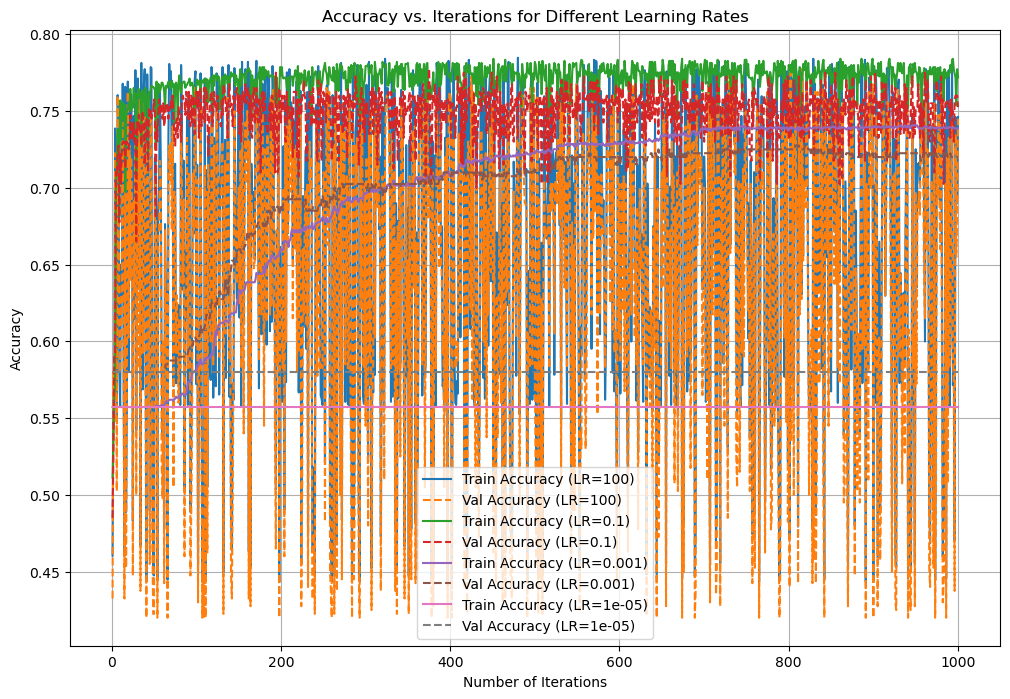

In [24]:
learning_rates_to_plot = [100, 0.1, 0.001, 0.00001]

# Plot accuracy vs. iterations
plot_accuracy_vs_iterations(
    X_train_normalized, y_train, X_val_normalized, y_val, 
    learning_rates=learning_rates_to_plot, epochs=1000
)

#### Question - 3
repeat 2 by plotting the average training loss and the dev loss instead of the accuracy.
The training and the dev losses are computed by dividing the loss sums by the number of samples.

In [26]:
def plot_loss_vs_iterations(X_train, y_train, X_val, y_val, learning_rates, epochs=1000, batch_size=16):
    """
    Train the model for specified learning rates and plot loss vs. iterations.
    """
    plt.figure(figsize=(12, 8))
    
    for lr in learning_rates:
        print(f"\nTraining for learning rate: {lr}")
        try:
            # Train the model and collect losses
            _, _, _, _, train_losses, val_losses = mini_batch_gradient_descent_with_tracking(
                X_train, y_train, X_val, y_val, learning_rate=lr, epochs=epochs, batch_size=batch_size
            )

            # Plot training and validation losses
            iterations = range(1, len(train_losses) + 1)
            plt.plot(iterations, train_losses, label=f"Train Loss (LR={lr})")
            plt.plot(iterations, val_losses, linestyle="--", label=f"Val Loss (LR={lr})")
        
        except OverflowError:
            print(f"Learning Rate {lr} caused an overflow and was skipped.")
    
    # Customize the plot
    plt.title("Loss vs. Iterations for Different Learning Rates")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Training for learning rate: 100


/var/folders/3q/qqkydbqd3cs819gns30k10840000gn/T/ipykernel_52483/401258560.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 50: Train Loss = 9.4781, Train Accuracy = 0.4827, Validation Loss = 10.1435, Validation Accuracy = 0.4450
Epoch 100: Train Loss = 10.2245, Train Accuracy = 0.4448, Validation Loss = 10.6840, Validation Accuracy = 0.4200
Epoch 150: Train Loss = 9.6903, Train Accuracy = 0.4705, Validation Loss = 10.3159, Validation Accuracy = 0.4400
Epoch 200: Train Loss = 3.9085, Train Accuracy = 0.7725, Validation Loss = 4.6797, Validation Accuracy = 0.7325
Epoch 250: Train Loss = 4.1191, Train Accuracy = 0.7617, Validation Loss = 5.0764, Validation Accuracy = 0.7100
Epoch 300: Train Loss = 4.0551, Train Accuracy = 0.7684, Validation Loss = 4.1722, Validation Accuracy = 0.7600
Epoch 350: Train Loss = 3.8985, Train Accuracy = 0.7745, Validation Loss = 4.7591, Validation Accuracy = 0.7250
Epoch 400: Train Loss = 7.4963, Train Accuracy = 0.5802, Validation Loss = 8.6111, Validation Accuracy = 0.5125
Epoch 450: Train Loss = 10.0986, Train Accuracy = 0.4509, Validation Loss = 10.6379, Validation Accur

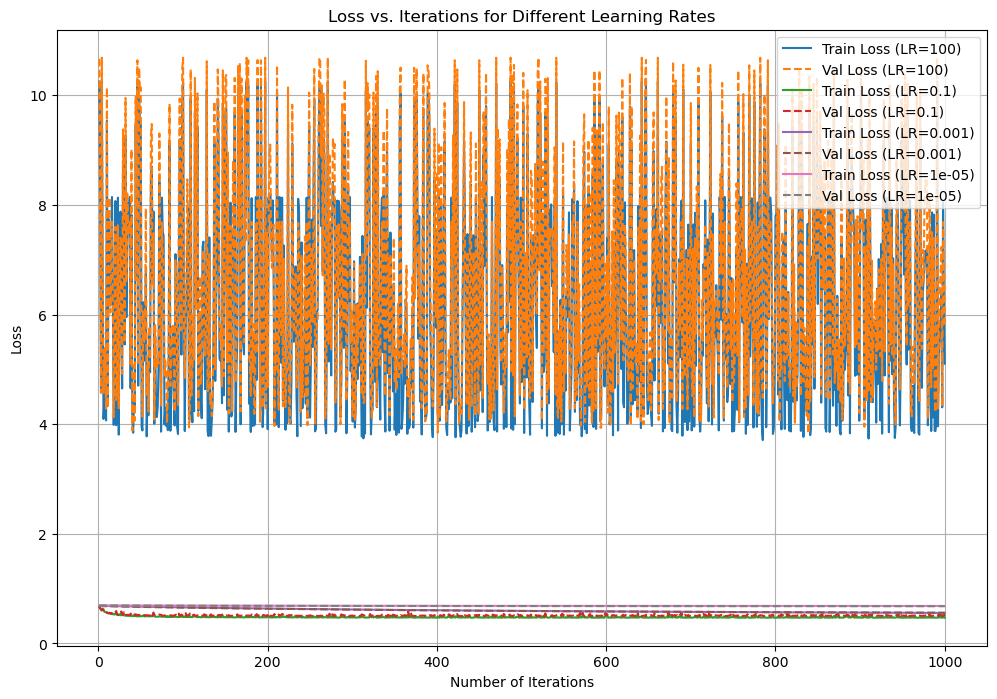

In [27]:
learning_rates_to_plot = [100, 0.1, 0.001, 0.00001]

# Plot loss vs. iterations
plot_loss_vs_iterations(
    X_train_normalized, y_train, X_val_normalized, y_val, 
    learning_rates=learning_rates_to_plot, epochs=1000
)

#### Question - 4
Plot the validation accuracy as a function of learning rate (the ones that did not lead to
overflow)? What do you observe? Which learning rate gave you the best results. The y-axis is the
accuracy, the x-axis is the learning rate (bar charts or dot charts are good choices for this question). 

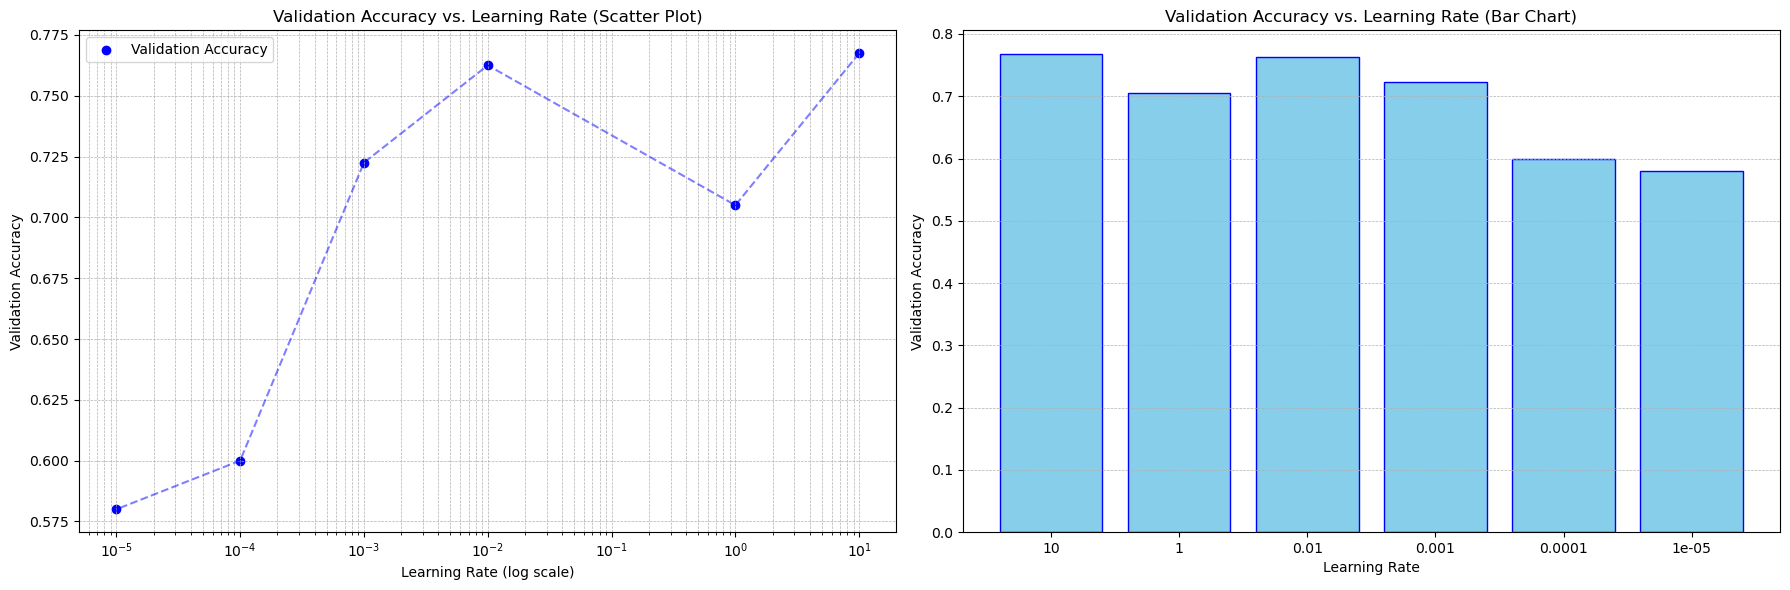

Best Learning Rate: 10
Validation Accuracy: 0.7675


In [29]:
def plot_validation_accuracy_vs_learning_rate(results):
    """
    Plot validation accuracy as a function of learning rate using both a scatter plot and a bar chart,
    displayed side by side.
    :param results: List of dictionaries with keys "Learning Rate" and "Validation Accuracy".
    """
    # Filter out overflow cases
    filtered_results = [res for res in results if res["Validation Accuracy"] != "Overflow"]
    
    # Extract learning rates and corresponding validation accuracies
    learning_rates = [res["Learning Rate"] for res in filtered_results]
    val_accuracies = [res["Validation Accuracy"] for res in filtered_results]
    
    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter Plot (First subplot)
    axes[0].scatter(learning_rates, val_accuracies, color='blue', label='Validation Accuracy')
    axes[0].plot(learning_rates, val_accuracies, color='blue', linestyle='--', alpha=0.5)
    axes[0].set_xscale('log')  # Log scale for learning rates for better visualization
    axes[0].set_title("Validation Accuracy vs. Learning Rate (Scatter Plot)")
    axes[0].set_xlabel("Learning Rate (log scale)")
    axes[0].set_ylabel("Validation Accuracy")
    axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)
    axes[0].legend()
    
    # Bar Chart (Second subplot)
    axes[1].bar([str(lr) for lr in learning_rates], val_accuracies, color='skyblue', edgecolor='blue')
    axes[1].set_title("Validation Accuracy vs. Learning Rate (Bar Chart)")
    axes[1].set_xlabel("Learning Rate")
    axes[1].set_ylabel("Validation Accuracy")
    axes[1].grid(axis='y', linestyle='--', linewidth=0.5)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    
    # Find the best learning rate
    best_result = max(filtered_results, key=lambda x: x["Validation Accuracy"])
    print(f"Best Learning Rate: {best_result['Learning Rate']}")
    print(f"Validation Accuracy: {best_result['Validation Accuracy']}")


# Using `results_1000_epochs` from Q1:

# Filter out results for learning rates 10000, 1000, and 100
filtered_results = [res for res in results_1000_epochs if res["Learning Rate"] not in [10000, 1000, 100]]

plot_validation_accuracy_vs_learning_rate(filtered_results) 

#### Question - 5
Report the testing accuracy that corresponds to the best learning rate (you decided from the previous step).
</br>Note: Use the best learning rate you got from the previous step to answer the following questions (I mean don’t re-tune it in order to limit the number of experiments you need to perform, not because this is the best practice)

In [31]:
# Train the model with the best learning rate
best_learning_rate = 0.01
epochs = 1000  # As per previous experiments
batch_size = 16

weights, bias, _, _, _, _ = mini_batch_gradient_descent_with_tracking(
    X_train_normalized, y_train, X_val_normalized, y_val, 
    learning_rate=best_learning_rate, epochs=epochs, batch_size=batch_size
)

# Evaluate the model on the test set
test_predictions = sigmoid(np.dot(X_test_normalized, weights) + bias) >= 0.5
test_accuracy = np.mean(test_predictions == y_test)

print(f"Testing Accuracy with best learning rate ({best_learning_rate}): {test_accuracy:.4f}")


Epoch 50: Train Loss = 0.5940, Train Accuracy = 0.7353, Validation Loss = 0.5939, Validation Accuracy = 0.7225
Epoch 100: Train Loss = 0.5565, Train Accuracy = 0.7400, Validation Loss = 0.5598, Validation Accuracy = 0.7200
Epoch 150: Train Loss = 0.5359, Train Accuracy = 0.7468, Validation Loss = 0.5435, Validation Accuracy = 0.7300
Epoch 200: Train Loss = 0.5229, Train Accuracy = 0.7536, Validation Loss = 0.5357, Validation Accuracy = 0.7250
Epoch 250: Train Loss = 0.5138, Train Accuracy = 0.7563, Validation Loss = 0.5289, Validation Accuracy = 0.7225
Epoch 300: Train Loss = 0.5073, Train Accuracy = 0.7603, Validation Loss = 0.5246, Validation Accuracy = 0.7350
Epoch 350: Train Loss = 0.5025, Train Accuracy = 0.7610, Validation Loss = 0.5221, Validation Accuracy = 0.7400
Epoch 400: Train Loss = 0.4987, Train Accuracy = 0.7617, Validation Loss = 0.5171, Validation Accuracy = 0.7475
Epoch 450: Train Loss = 0.4954, Train Accuracy = 0.7644, Validation Loss = 0.5161, Validation Accuracy = 

#### Question - 6
Try different batch sizes (4, 8, 16, 32, 64) and plot the validation Accuracy for these
values in one figure, which batch size gave the best performance ()? 

In [33]:
def experiment_batch_sizes(X_train, y_train, X_val, y_val, learning_rate, batch_sizes, epochs=1000):
    """
    Experiment with different batch sizes and report validation accuracy.
    """
    results = []

    for batch_size in batch_sizes:
        print(f"\nTesting batch size: {batch_size}")
        try:
            # Train the model with the current batch size
            _, _, _, val_accuracies, _, _ = mini_batch_gradient_descent_with_tracking(
                X_train, y_train, X_val, y_val, learning_rate=learning_rate, epochs=epochs, batch_size=batch_size
            )

            # Record the final validation accuracy
            final_val_accuracy = val_accuracies[-1]
            results.append({"Batch Size": batch_size, "Validation Accuracy": final_val_accuracy})
            print(f"Batch Size {batch_size}: Validation Accuracy = {final_val_accuracy:.4f}")
        
        except Exception as e:
            print(f"Batch Size {batch_size} caused an error: {e}")
            results.append({"Batch Size": batch_size, "Validation Accuracy": "Error"})

    return results

In [34]:
def plot_validation_accuracy_vs_batch_size(results):
    """
    Plot validation accuracy as a function of batch size.
    """
    # Extract batch sizes and validation accuracies
    batch_sizes = [res["Batch Size"] for res in results if res["Validation Accuracy"] != "Error"]
    val_accuracies = [res["Validation Accuracy"] for res in results if res["Validation Accuracy"] != "Error"]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar([str(bs) for bs in batch_sizes], val_accuracies, color='lightgreen', edgecolor='green')
    plt.title("Validation Accuracy vs. Batch Size")
    plt.xlabel("Batch Size")
    plt.ylabel("Validation Accuracy")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()
    
    # Find the best batch size
    best_result = max(results, key=lambda x: x["Validation Accuracy"] if x["Validation Accuracy"] != "Error" else 0)
    print(f"Best Batch Size: {best_result['Batch Size']}")
    print(f"Validation Accuracy: {best_result['Validation Accuracy']}")



Testing batch size: 4
Epoch 50: Train Loss = 0.5243, Train Accuracy = 0.7549, Validation Loss = 0.5322, Validation Accuracy = 0.7325
Epoch 100: Train Loss = 0.4989, Train Accuracy = 0.7617, Validation Loss = 0.5206, Validation Accuracy = 0.7450
Epoch 150: Train Loss = 0.4899, Train Accuracy = 0.7651, Validation Loss = 0.5105, Validation Accuracy = 0.7525
Epoch 200: Train Loss = 0.4839, Train Accuracy = 0.7644, Validation Loss = 0.5103, Validation Accuracy = 0.7575
Epoch 250: Train Loss = 0.4816, Train Accuracy = 0.7718, Validation Loss = 0.5119, Validation Accuracy = 0.7525
Epoch 300: Train Loss = 0.4785, Train Accuracy = 0.7725, Validation Loss = 0.5075, Validation Accuracy = 0.7625
Epoch 350: Train Loss = 0.4792, Train Accuracy = 0.7718, Validation Loss = 0.5129, Validation Accuracy = 0.7475
Epoch 400: Train Loss = 0.4756, Train Accuracy = 0.7752, Validation Loss = 0.5033, Validation Accuracy = 0.7625
Epoch 450: Train Loss = 0.4747, Train Accuracy = 0.7766, Validation Loss = 0.5023,

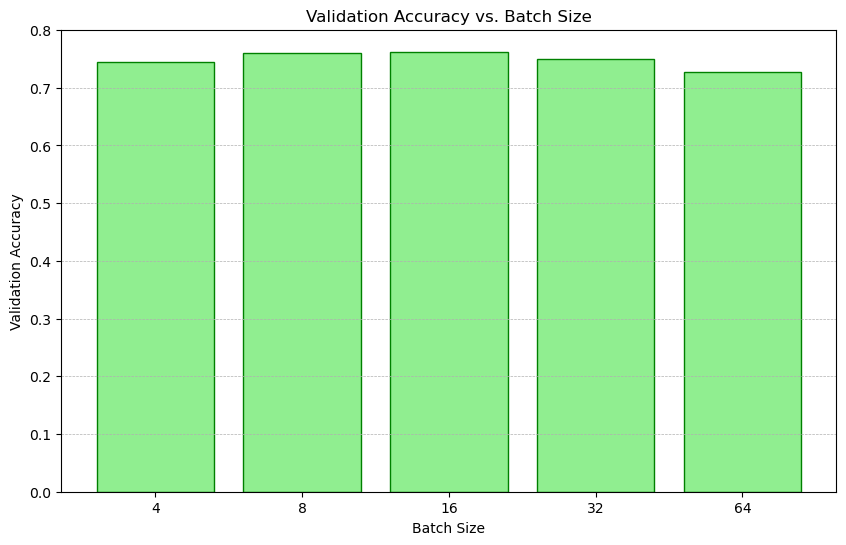

Best Batch Size: 16
Validation Accuracy: 0.7625


In [36]:
# Experiment with different batch sizes
batch_sizes_to_test = [4, 8, 16, 32, 64]
learning_rate_for_batch_experiment = 0.01  

batch_results = experiment_batch_sizes(
    X_train_normalized, y_train, X_val_normalized, y_val, 
    learning_rate=learning_rate_for_batch_experiment, batch_sizes=batch_sizes_to_test, epochs=1000
)

# Plot the results
plot_validation_accuracy_vs_batch_size(batch_results)


#### Question - 7
Add L2 regularization to the implementation of gradient decent, what did you add to
your implementation? Did adding L2 regularization change to the best validation and testing
accuracy you have got? What is the value of 𝜆 you have chosen and why? Do you recommend using
regularization? Plot the training and the validation accuracy for different values of 𝜆, you the best
learning rate value you have obtained to do this part.

Training with λ = 0.01
Epoch 50: Train Loss=0.5947, Train Accuracy=0.7123, Val Loss=0.5921, Val Accuracy=0.7125
Epoch 100: Train Loss=0.5585, Train Accuracy=0.7400, Val Loss=0.5619, Val Accuracy=0.7225
Epoch 150: Train Loss=0.5389, Train Accuracy=0.7427, Val Loss=0.5460, Val Accuracy=0.7300
Epoch 200: Train Loss=0.5265, Train Accuracy=0.7508, Val Loss=0.5372, Val Accuracy=0.7350
Epoch 250: Train Loss=0.5182, Train Accuracy=0.7569, Val Loss=0.5330, Val Accuracy=0.7225
Epoch 300: Train Loss=0.5122, Train Accuracy=0.7576, Val Loss=0.5266, Val Accuracy=0.7425
Epoch 350: Train Loss=0.5076, Train Accuracy=0.7603, Val Loss=0.5243, Val Accuracy=0.7475
Epoch 400: Train Loss=0.5047, Train Accuracy=0.7637, Val Loss=0.5205, Val Accuracy=0.7450
Epoch 450: Train Loss=0.5016, Train Accuracy=0.7617, Val Loss=0.5193, Val Accuracy=0.7475
Epoch 500: Train Loss=0.4993, Train Accuracy=0.7630, Val Loss=0.5183, Val Accuracy=0.7500
Epoch 550: Train Loss=0.4975, Train Accuracy=0.7644, Val Loss=0.5169, Val Accu

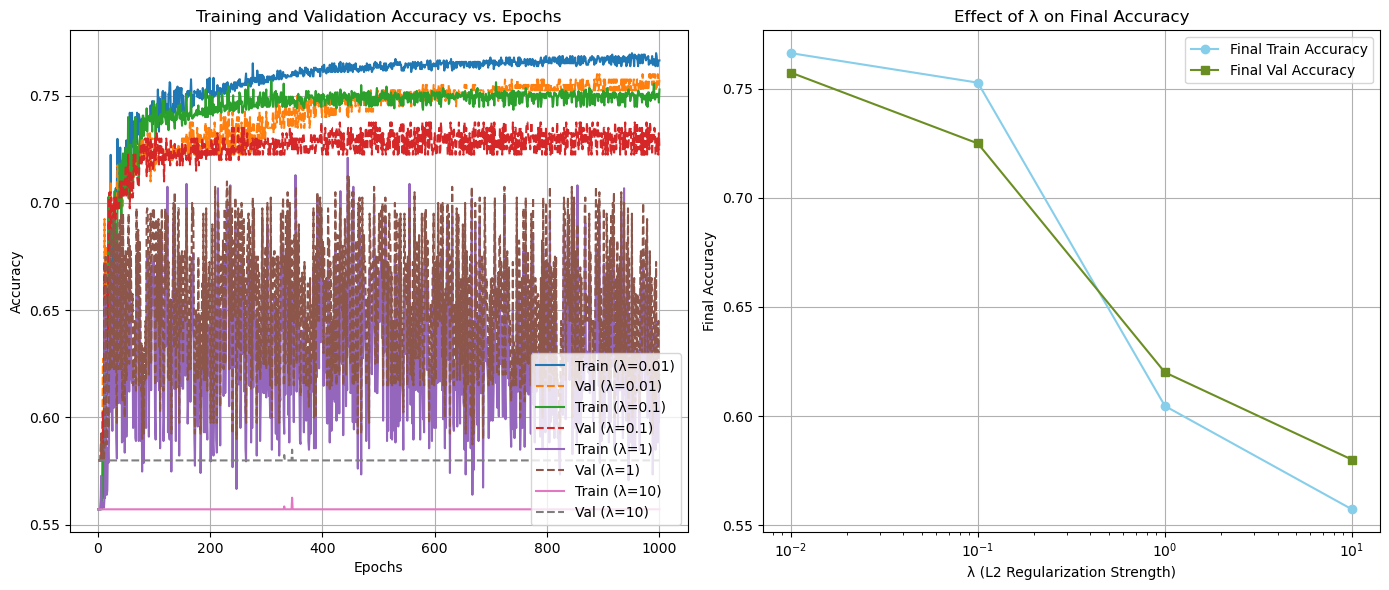

In [38]:
def compute_loss_and_gradients_l2(X, y, weights, bias, lambda_reg):
    """
    Compute the binary cross-entropy loss and gradients with L2 regularization.
    """
    m = X.shape[0]  # Number of samples

    # Predictions and loss
    z = np.dot(X, weights) + bias
    predictions = sigmoid(z)
    cross_entropy_loss = -(1 / m) * np.sum(
        y * np.log(predictions + 1e-8) + (1 - y) * np.log(1 - predictions + 1e-8)
    )
    l2_loss = (lambda_reg / (2 * m)) * np.sum(weights**2)
    loss = cross_entropy_loss + l2_loss

    # Gradients
    dw = (1 / m) * np.dot(X.T, (predictions - y)) + (lambda_reg / m) * weights
    db = (1 / m) * np.sum(predictions - y)

    return loss, dw, db

def mini_batch_gradient_descent_l2(X, y, X_val, y_val, learning_rate, lambda_reg, epochs=1000, batch_size=16):
    """
    Train logistic regression using mini-batch gradient descent with L2 regularization.
    """
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Shuffle data
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled, y_shuffled = X[indices], y[indices]

        # Mini-batch processing
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Compute gradients and update parameters
            loss, dw, db = compute_loss_and_gradients_l2(X_batch, y_batch, weights, bias, lambda_reg)
            weights -= learning_rate * dw
            bias -= learning_rate * db

        # Evaluate train/validation sets
        train_predictions = sigmoid(np.dot(X, weights) + bias) >= 0.5
        val_predictions = sigmoid(np.dot(X_val, weights) + bias) >= 0.5
        train_accuracies.append(np.mean(train_predictions == y))
        val_accuracies.append(np.mean(val_predictions == y_val))

        train_loss, _, _ = compute_loss_and_gradients_l2(X, y, weights, bias, lambda_reg)
        val_loss, _, _ = compute_loss_and_gradients_l2(X_val, y_val, weights, bias, lambda_reg)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Epoch logging
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Accuracy={train_accuracies[-1]:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracies[-1]:.4f}")

    return weights, bias, train_accuracies, val_accuracies, train_losses, val_losses

def plot_training_validation_accuracy(lambdas, train_accuracies, val_accuracies):
    """
    Plot the effect of L2 regularization (lambda) on training and validation accuracy.
    """
    plt.figure(figsize=(14, 6))

    # Subplot 1: Accuracy vs. Epochs for different lambdas
    plt.subplot(1, 2, 1)
    for i, lambda_reg in enumerate(lambdas):
        plt.plot(range(1, len(train_accuracies[i]) + 1), train_accuracies[i], label=f"Train (λ={lambda_reg})")
        plt.plot(range(1, len(val_accuracies[i]) + 1), val_accuracies[i], linestyle="--", label=f"Val (λ={lambda_reg})")

    plt.title("Training and Validation Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid(True)

    # Subplot 2: Final accuracies vs. lambdas
    plt.subplot(1, 2, 2)
    final_train = [acc[-1] for acc in train_accuracies]
    final_val = [acc[-1] for acc in val_accuracies]
    plt.plot(lambdas, final_train, marker="o", label="Final Train Accuracy", color="skyblue")
    plt.plot(lambdas, final_val, marker="s", label="Final Val Accuracy", color="olivedrab")

    plt.xscale("log")
    plt.xlabel("λ (L2 Regularization Strength)")
    plt.ylabel("Final Accuracy")
    plt.title("Effect of λ on Final Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def experiment_with_l2(X_train, y_train, X_val, y_val, learning_rate, lambdas, epochs=1000, batch_size=16):
    """
    Train with multiple λ values and plot results.
    """
    all_train_accuracies = []
    all_val_accuracies = []

    for lambda_reg in lambdas:
        print(f"Training with λ = {lambda_reg}")
        _, _, train_accuracies, val_accuracies, _, _ = mini_batch_gradient_descent_l2(
            X_train, y_train, X_val, y_val, learning_rate, lambda_reg, epochs, batch_size
        )
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

    plot_training_validation_accuracy(lambdas, all_train_accuracies, all_val_accuracies)

# Example usage
lambda_values = [0.01, 0.1, 1, 10]
learning_rate = 0.01
experiment_with_l2(X_train_normalized, y_train, X_val_normalized, y_val, learning_rate, lambda_values)


#### Question - 8 
train a model without data normalization, does it work? Is it easy to train? Did you need
more iterations? Explain your observation? Which rate of learning works the best for unnormalized
data? (Do similar plot for 3 learning rate values of your choice like the plots in part Q1.


Training without normalization for learning rate: 0.1
Epoch 50: Train Loss=0.5455, Train Accuracy=0.7508, Val Loss=0.5504, Val Accuracy=0.7300
Epoch 100: Train Loss=0.5244, Train Accuracy=0.7610, Val Loss=0.5340, Val Accuracy=0.7400
Epoch 150: Train Loss=0.5173, Train Accuracy=0.7617, Val Loss=0.5286, Val Accuracy=0.7475
Epoch 200: Train Loss=0.5270, Train Accuracy=0.7366, Val Loss=0.5302, Val Accuracy=0.7475
Epoch 250: Train Loss=0.5121, Train Accuracy=0.7664, Val Loss=0.5286, Val Accuracy=0.7500
Epoch 300: Train Loss=0.5131, Train Accuracy=0.7624, Val Loss=0.5238, Val Accuracy=0.7475
Epoch 350: Train Loss=0.5106, Train Accuracy=0.7684, Val Loss=0.5276, Val Accuracy=0.7500
Epoch 400: Train Loss=0.5131, Train Accuracy=0.7691, Val Loss=0.5341, Val Accuracy=0.7450
Epoch 450: Train Loss=0.5214, Train Accuracy=0.7400, Val Loss=0.5267, Val Accuracy=0.7425
Epoch 500: Train Loss=0.5099, Train Accuracy=0.7671, Val Loss=0.5259, Val Accuracy=0.7450
Epoch 550: Train Loss=0.5149, Train Accuracy=0

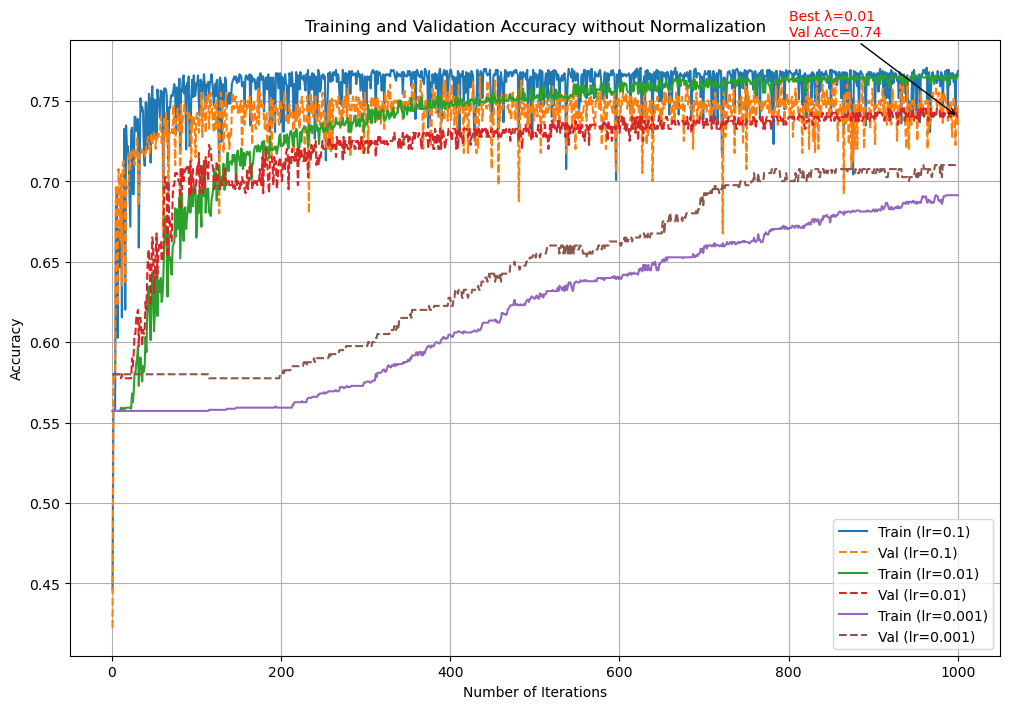


Results Summary (Without Normalization):
   Learning Rate  Train Accuracy  Validation Accuracy
0          0.100        0.768450                0.735
1          0.010        0.766418                0.740
2          0.001        0.691266                0.710

Best Learning Rate (Without Normalization): 0.01
Train Accuracy: 0.7664184157075152
Validation Accuracy: 0.74


In [40]:
def experiment_without_normalization(X_train, y_train, X_val, y_val, learning_rates, epochs=1000, batch_size=16):
    """
    Train the logistic regression model on unnormalized data and evaluate the effect of learning rates.
    """
    results = []
    plt.figure(figsize=(12, 8))

    for lr in learning_rates:
        print(f"\nTraining without normalization for learning rate: {lr}")
        try:
            # Train the model using the current learning rate
            weights, bias, train_accuracies, val_accuracies, _, _ = mini_batch_gradient_descent_l2(
                X_train, y_train, X_val, y_val, learning_rate=lr, lambda_reg=0.01, epochs=epochs, batch_size=batch_size
            )

            # Record the final training and validation accuracy
            final_train_accuracy = train_accuracies[-1]
            final_val_accuracy = val_accuracies[-1]
            results.append({
                "Learning Rate": lr,
                "Train Accuracy": final_train_accuracy,
                "Validation Accuracy": final_val_accuracy
            })

            # Plot training and validation accuracy
            iterations = range(1, len(train_accuracies) + 1)
            plt.plot(iterations, train_accuracies, label=f"Train (lr={lr})")
            plt.plot(iterations, val_accuracies, linestyle="--", label=f"Val (lr={lr})")

        except OverflowError:
            # Handle overflow for large learning rates
            print(f"Learning Rate {lr} caused an overflow.")
            results.append({
                "Learning Rate": lr,
                "Train Accuracy": "Overflow",
                "Validation Accuracy": "Overflow"
            })

    # Determine the best learning rate based on validation accuracy
    best_result = max(results, key=lambda x: x["Validation Accuracy"] if isinstance(x["Validation Accuracy"], (int, float)) else -1)

    # Annotate the plot with the best learning rate
    if best_result["Validation Accuracy"] != "Overflow":
        best_lr = best_result["Learning Rate"]
        best_val_accuracy = best_result["Validation Accuracy"]
        plt.annotate(
            f"Best λ={best_lr}\nVal Acc={best_val_accuracy:.2f}",
            xy=(epochs, best_val_accuracy),
            xytext=(epochs - 200, best_val_accuracy + 0.05),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=10,
            color="red"
        )

    # Customize the plot
    plt.title("Training and Validation Accuracy without Normalization")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return a summary of the results
    return results, best_result


# Learning rates to test
learning_rates = [0.1, 0.01, 0.001]

# Run the experiment without normalization
results_without_normalization, best_result_without_normalization = experiment_without_normalization(
    X_train, y_train, X_val, y_val, learning_rates
)

# Display results in a table
results_df = pd.DataFrame(results_without_normalization)
print("\nResults Summary (Without Normalization):")
print(results_df)

# Print the best learning rate and corresponding accuracies
if best_result_without_normalization["Validation Accuracy"] != "Overflow":
    print(f"\nBest Learning Rate (Without Normalization): {best_result_without_normalization['Learning Rate']}")
    print(f"Train Accuracy: {best_result_without_normalization['Train Accuracy']}")
    print(f"Validation Accuracy: {best_result_without_normalization['Validation Accuracy']}")
else:
    print("\nNo suitable learning rate found due to overflows.")